In [1]:
!pip install ast

ERROR: Could not find a version that satisfies the requirement ast (from versions: 0.0.1, 0.0.2)
ERROR: No matching distribution found for ast


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DataSets/the-movies-dataset/movies_metadata_fixed.csv')
df.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415


In [5]:
df.shape

(45463, 24)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  bool   
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  int64  
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   id                     45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45463 non-null  float64
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re



---

# Drop columns

---



In [7]:
df = df[['title', 'release_date', 'vote_count', 'vote_average', 'genres']]
df.head()

,title,release_date,vote_count,vote_average,genres
0,Toy Story,1995-10-30,5415,7.7,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,1995-12-15,2413,6.9,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,1995-12-22,92,6.5,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,1995-12-22,34,6.1,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,1995-02-10,173,5.7,"[{'id': 35, 'name': 'Comedy'}]"


---
# Checking for outliers
---

Conclusions regarding the correctness of the values were based on the knowledge of the domain.

In [8]:
min_vote_count, max_vote_count = df['vote_count'].quantile([0, 1])
min_vote_count, max_vote_count

(0.0, 14075.0)

In [9]:
min_vote_average, max_vote_average = df['vote_average'].quantile([0, 1])
min_vote_average, max_vote_average

(0.0, 10.0)



---

# Handling the 'genres' column

---



In [10]:
def handling_genres_column(data):
  data['genres'] = data['genres'].fillna('[]') \
                             .apply(ast.literal_eval) \
                             .apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
  return data

In [11]:
# Unique values for the "genres" column
def unique_values_for_genres(data):
  genres = []
  count_of_oblects = data.shape[0]
  for i in range(count_of_oblects):
    for k in data.iloc[i][4]:
      if k not in genres:
        genres.append(k)
  return genres

In [12]:
df = handling_genres_column(df)
df.head(1)

,title,release_date,vote_count,vote_average,genres
0,Toy Story,1995-10-30,5415,7.7,"[Animation, Comedy, Family]"


In [13]:
unique_values_for_genres(df)

['Animation',
 'Comedy',
 'Family',
 'Adventure',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'History',
 'Science Fiction',
 'Mystery',
 'War',
 'Foreign',
 'Music',
 'Documentary',
 'Western',
 'TV Movie']

In [14]:
mlb = MultiLabelBinarizer(sparse_output=True)

df = df.join(pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('genres')),
                index=df.index,
                columns=mlb.classes_))

In [15]:
df.head()

,title,release_date,vote_count,vote_average,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Toy Story,1995-10-30,5415,7.7,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Jumanji,1995-12-15,2413,6.9,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,1995-12-22,92,6.5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Waiting to Exhale,1995-12-22,34,6.1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Father of the Bride Part II,1995-02-10,173,5.7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




---

# Create the 'weight' column

---



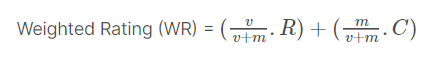

Where,


 

*   u is the number of votes for the movie
*   m is the minimum votes required to be listed in the chart
*   R is the average rating of the movie
*   C is the mean vote across the whole report


  
  
  

In [16]:
u = df['vote_count']
m = df['vote_count'].quantile(0.95)
R =  df['vote_average']
C = df['vote_average'].mean()

In [17]:
df['weight'] = ((u / (u + m)) * R) + ((m / (u + m)) * C)



---

# Work with column names

---



In [18]:
df = df[['title', 'release_date', 'vote_count', 'vote_average', 'weight', 
         'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
         'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
         'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller',
         'War', 'Western']]

In [19]:
df = df.rename(columns={'Science Fiction': 'Science_Fiction', 'TV Movie': 'TV_Movie'})

In [20]:
df.columns = map(str.lower, df.columns)

In [21]:
df.head(1)

,title,release_date,vote_count,vote_average,weight,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,Toy Story,1995-10-30,5415,7.7,7.545563,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0




---

# General Rating Recommendation System

---



In [22]:
# To avoid infinity in the "weights" column
df = df[df.vote_count != 0]

In [23]:
df = df[df.vote_average != 0]

In [24]:
df.sort_values('vote_average', ascending=False).head()

,title,release_date,vote_count,vote_average,weight,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
37332,Book of Days,1989-11-30,1,10.0,5.628292,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15249,Ween: Live in Chicago,2004-05-04,1,10.0,5.628292,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15397,Little Dorrit,1987-12-11,1,10.0,5.628292,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
33278,Dream Deceivers: The Story Behind James Vance ...,1992-08-06,1,10.0,5.628292,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45359,The Many Faces of Christopher Lee,1996-01-01,1,10.0,5.628292,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# Output is 50 best movies in different genres
def general_vote(data):
  return data.sort_values('weight', ascending=False).head(50)

In [26]:
general_vote(df)

,title,release_date,vote_count,vote_average,weight,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
314,The Shawshank Redemption,1994-09-23,8358,8.5,8.357778,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
834,The Godfather,1972-03-14,6024,8.5,8.306376,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12481,The Dark Knight,2008-07-16,12269,8.3,8.208397,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2843,Fight Club,1999-10-15,9678,8.3,8.184925,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
292,Pulp Fiction,1994-09-10,8670,8.3,8.172184,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
351,Forrest Gump,1994-07-06,8147,8.2,8.069450,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
522,Schindler's List,1993-11-29,4436,8.3,8.061058,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
23672,Whiplash,2014-10-10,4376,8.3,8.058077,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5481,Spirited Away,2001-07-20,3968,8.3,8.035654,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1154,The Empire Strikes Back,1980-05-17,5998,8.2,8.025831,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0




---

# Rating Recommender System by Genre

---



In [27]:
# Output is 50 best movies in definite genre. Input must be in lower case.
def genres_vote(data, genre):
  return data[data[genre] == 1].sort_values('weight', ascending=False).head(50)

In [28]:
genres_vote(df, 'crime')

,title,release_date,vote_count,vote_average,weight,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
314,The Shawshank Redemption,1994-09-23,8358,8.5,8.357778,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
834,The Godfather,1972-03-14,6024,8.5,8.306376,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12481,The Dark Knight,2008-07-16,12269,8.3,8.208397,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
292,Pulp Fiction,1994-09-10,8670,8.3,8.172184,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1178,The Godfather: Part II,1974-12-20,3418,8.3,7.997909,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
289,Leon: The Professional,1994-09-14,4293,8.2,7.963008,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3030,The Green Mile,1999-12-10,4166,8.2,7.956465,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
46,Se7en,1995-09-22,5915,8.1,7.930389,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1170,GoodFellas,1990-09-12,3211,8.2,7.892657,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
586,The Silence of the Lambs,1991-02-01,4549,8.1,7.883892,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [34]:
genres_vote(df, 'fantasy')

,title,release_date,vote_count,vote_average,weight,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
5481,Spirited Away,2001-07-20,3968,8.3,8.035654,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
7000,The Lord of the Rings: The Return of the King,2003-12-01,8226,8.1,7.975651,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3030,The Green Mile,1999-12-10,4166,8.2,7.956465,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4863,The Lord of the Rings: The Fellowship of the Ring,2001-12-18,8892,8.0,7.889184,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5814,The Lord of the Rings: The Two Towers,2002-12-18,7641,8.0,7.872016,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
17437,Harry Potter and the Deathly Hallows: Part 2,2011-07-07,6141,7.9,7.749417,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
9698,Howl's Moving Castle,2004-11-19,2049,8.2,7.748820,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2884,Princess Mononoke,1997-07-12,2041,8.2,7.747361,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7725,Harry Potter and the Prisoner of Azkaban,2004-05-31,6037,7.7,7.560408,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
5833,My Neighbor Totoro,1988-04-16,1730,8.0,7.522411,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
